# Import and Setup

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import sys

import glob
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
params = {'font.size':14,'font.family':'lmodern','xtick.labelsize':16, 'ytick.labelsize':16,}

# plt.style.use('../../style.mplstyle')
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import erfc

# Data Read-In

In [3]:
D1 = Dataset.Dataset(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210913/', Selection='*.h5')
# files1 = glob.glob('/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210913/*')
files2 = glob.glob('/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/*')
# for file in files2:
#     files1.append(file)

# D1.Files = files1
D1.Files = files2
for File in D1.Files:
    print(File)
    D1.ImportDataFromHDF5(File, D1.Ch)

/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_8.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_3.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_5.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_2.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_0.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_7.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_1.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_4.h5
/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20210914/SiPM_33V_-99C_LED_trigger_6.h5


 | Processing data in channel 1...
 | Subtracting baseline...


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 | Removing noise...


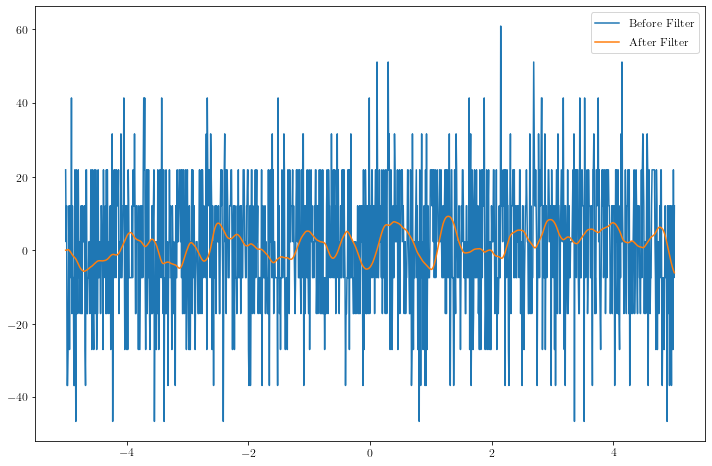

 | Getting extrema of individual files...
 | Getting average waveform...
 | Processing data in channel 2...
 | Subtracting baseline...


/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/chroma/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 | Removing noise...


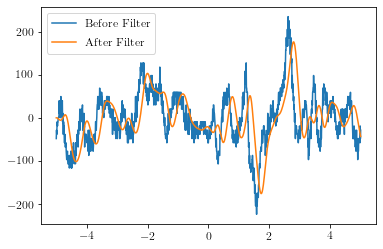

 | Getting extrema of individual files...
 | Getting average waveform...


In [13]:
Print=True
fig = plt.figure(figsize=(12,8))
time=np.linspace(-5,5,1256)
for ii, ch in enumerate(D1.Ch):
    print(" | Processing data in channel %d..." % (ch.ID))
    ch.GetSampling()
#     print(ch.Amp)
#     ch.Amp = [x for _, x in sorted(zip(ch.TimeStamp, ch.Amp))]
    ch.Amp = np.array(ch.Amp)
#     print (ch.Amp)
    ch.TimeStamp = np.array(sorted(ch.TimeStamp))

    ch.Amp = ch.SubtractBaseline(Data=ch.Amp, state=Print)
    plt.plot(time,ch.Amp[0],label='Before Filter')  
    
    ch.Amp = ch.RemoveNoise(Data=ch.Amp, HighPass=2000000, state=Print)
    plt.plot(time,ch.Amp[0],label='After Filter') 
    plt.legend()
    plt.show()
    ch.GetAllMaxima(Data=ch.Amp, state=Print)# Look at the code for the time window. Add a time window argument
    ch.GetIntegral(Data=ch.Amp, state=Print)# Look at the code for the time window. Add a time window argument
#         ch.RunFit(Data=D1.Ch[1].Amp)


In [5]:
print("Time=",D1.Ch[0].Time)
print("Integral=",D1.Ch[0].Integral)
print("Samples=",D1.Ch[0].Samples)
print('Total Time=',D1.Ch[0].TotalTime,'us')
print("Sampling=",D1.Ch[0].Sampling)
print("Size Amplitude=",len(D1.Ch[0].Amp[2]))

Sampling_Frequency=1000000/((D1.Ch[0].Time[1])-(D1.Ch[0].Time[0]))
Time_Min=D1.Ch[0].Time.min()
Time_Max=D1.Ch[0].Time.max()
print("Time Min ($/mu$s)=",Time_Min)
print("Time Max ($/mu$s)=",Time_Max)
print("Sampling Frequency (per second)=",Sampling_Frequency)

Time= [-5.    -4.992 -4.984 ...  5.024  5.032  5.04 ]
Integral= [-130.0625   111.84375 -209.1875  ... -192.1875    27.09375 -240.125  ]
Samples= 1256
Total Time= 10.04 us
Sampling= 125099601.59362552
Size Amplitude= 2512
Time Min ($/mu$s)= -5.0
Time Max ($/mu$s)= 5.04
Sampling Frequency (per second)= 125000000.00001377


In [6]:
print(D1.Ch[0].Amp[0])

[21.84375   2.3125   12.078125 ... 21.84375  -7.453125 12.078125]


Base= -13.736687863978483 V0= 219.825531081074 sigma= 0.04603363812672243 tau= 0.15334537502853807 mu= 0.6158172907319336


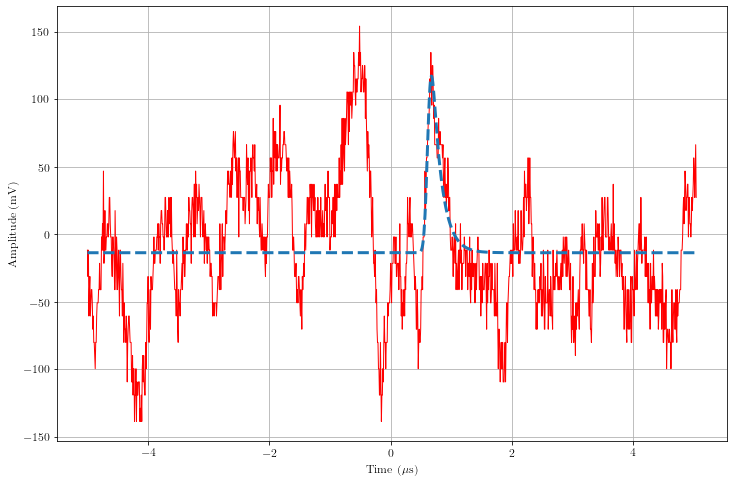

In [7]:
def func(x,Base,V0,sigma,tau,mu):
        return Base + 0.5*V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (sigma/tau - (x-mu)/sigma))
fig = plt.figure(figsize=(12,8))

plt.plot(D1.Ch[1].Time,-D1.Ch[1].Amp[25],color='r',lw=1)

xdata=D1.Ch[1].Time
ydata=-D1.Ch[1].Amp[25]
        
popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000000,p0=[0,100,0.5,0.5,0.5])
        
# print("integral_curve=",D1.Ch[1].GetIntegral(Data=func(xdata,*popt), state=Print))
plt.plot(xdata,func(xdata,*popt),'--',lw=3)
print ("Base=",popt[0],"V0=",popt[1],"sigma=",popt[2],"tau=",popt[3],"mu=",popt[4])



plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (mV)')
# plt.xlim(-2,2)
# plt.ylim(0,500)
# plt.legend(loc=2,fontsize=14,framealpha=0.8)
plt.grid()
plt.show()


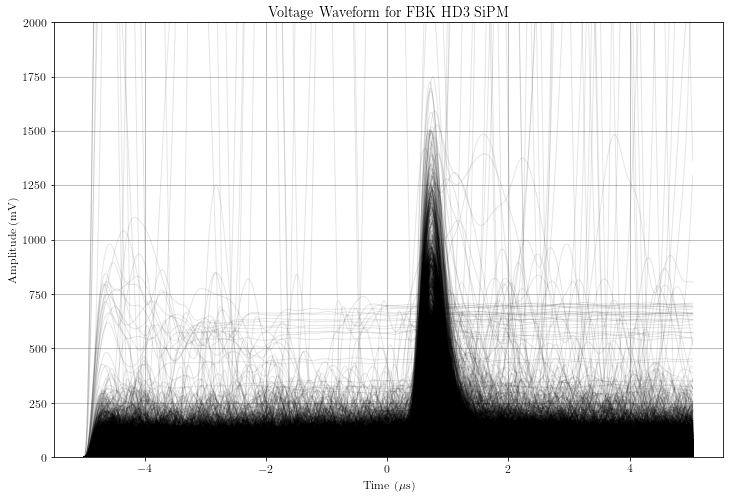

In [10]:
fig = plt.figure(figsize=(12,8))

time=np.arange(Time_Min,Time_Max,1000000/Sampling_Frequency)
maxima= []

for ii,amp in enumerate(D1.Ch[1].Amp):
    amp = amp*-1
    if len(amp)==2512:
        pass
    else:
        plt.plot(time,amp, color='k', lw=1, alpha=0.1)
        maxima.append(np.max(amp))
# plt.xlim(0,2)
plt.ylim(0,2000)
plt.title("Voltage Waveform for FBK HD3 SiPM")
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.show()
# fig.savefig('Waveform_highpass_2000000.pdf', dpi=500)

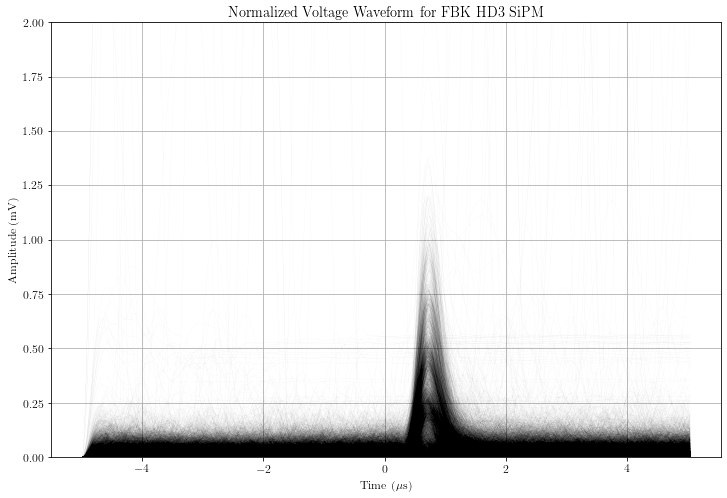

(9435, 1256)


In [12]:
fig = plt.figure(figsize=(12,8))

normalized_wf=[]
for ii,amp in enumerate(D1.Ch[1].Amp):
    amp = amp*-1
    if len(amp)==2512:
        pass
    else:
        normalized_wf.append(amp/len(amp))
        plt.plot(time,amp/len(amp), color='k', lw=0.1, alpha=0.1)        
# plt.xlim(0,2)
plt.ylim(0,2)
plt.title("Normalized Voltage Waveform for FBK HD3 SiPM")
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.show()
fig.savefig('Waveform_highpass_2000000_normalized.pdf', dpi=500)
normalized_wf=np.asarray(normalized_wf)
print(normalized_wf.shape)
# print (normalized_wf)

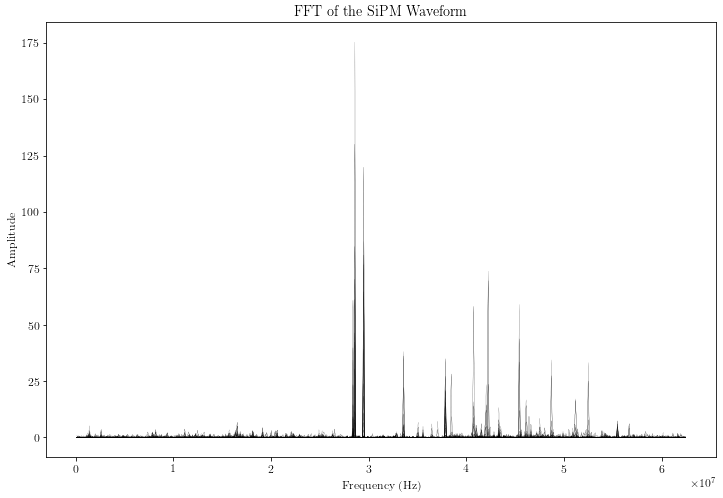

In [28]:
fig = plt.figure(figsize=(12,8))

dt=1/D1.Ch[0].Sampling
n = len(D1.Ch[0].Amp[2])
fhat = np.fft.fft(normalized_wf, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

plt.plot(freq[idxs_half],np.abs(psd[idxs_half]),color='k',lw=0.1)
plt.title("FFT of the SiPM Waveform")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
# plt.grid()
plt.show()
fig.savefig('Waveform_FFT_new_method.pdf', dpi=500)

In [29]:
psd_idxs=(psd<20)
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal
signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

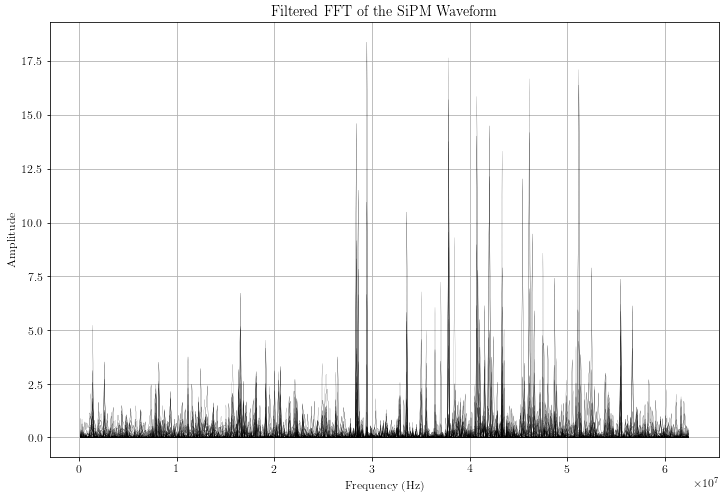

In [30]:
fig = plt.figure(figsize=(12,8))
plt.plot(freq[idxs_half],np.abs(psd_clean[idxs_half]),color='k',lw=0.1)
plt.title("Filtered FFT of the SiPM Waveform")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()
# fig.savefig('Waveform_FFT_filtered_new_method.pdf', dpi=500)

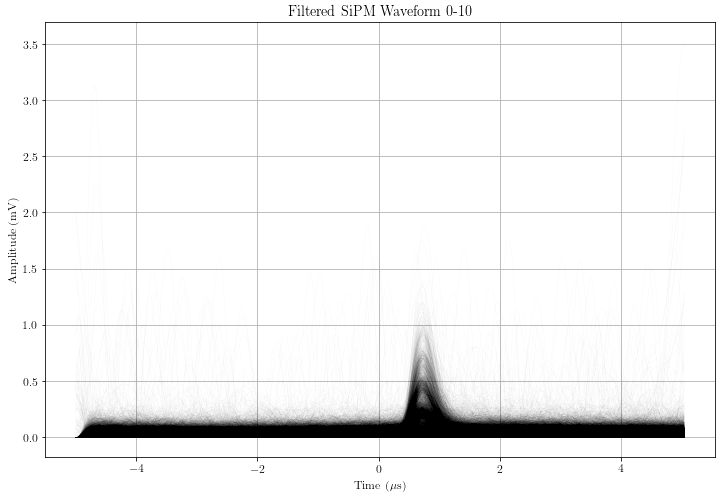

In [31]:
fig = plt.figure(figsize=(12,8))


for waveforms in signal_filtered:
    plt.plot(time,np.abs(waveforms), color='k', lw=0.1, alpha=0.1)
    
plt.title("Filtered SiPM Waveform 0-10")
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (mV)')
# plt.xlim(0,2)
# plt.ylim(0,2)
plt.grid()
plt.show()
# fig.savefig('Waveform_highpass_2000000_filtered0-10.pdf', dpi=500)

In [ ]:
xdata=[]
ydata=[]
popt=[]
pcov=[]

Base=[]
V0=[]
sigma=[]
tau=[]
mu=[]

func_data=[]

def func(x,Base,V0,sigma,tau,mu):
        return Base + 0.5*V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (sigma/tau - (x-mu)/sigma))

# fig = plt.figure(figsize=(12,8))

for waveforms in signal_filtered:
    xdata=time
    ydata=np.abs(waveforms)
    popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000000,p0=[0,10,0.5,0.5,0.5])
    Base.append(popt[0])
    V0.append(popt[1])
    sigma.append(popt[2])
    tau.append(popt[3])
    mu.append(popt[4])
    func_data.append(func(xdata,*popt))

ch.GetIntegral(Data=func_data,state=Print)

In [ ]:
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,50,250)
plt.hist(D1.Ch[1].Integral, bins=BINS, histtype='step',lw=2)
plt.title("Histogram of Integrals between 0.5$\mu$s and 1.0$\mu$s from fit function")
plt.xlabel('Integral')
plt.ylabel('Number of entries')
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
Amplitude=((np.array(V0)/0.5))-np.array(Base)
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,300,900)
plt.hist(Amplitude, bins=BINS, histtype='step',lw=2,label='Amplitude')

plt.yscale('log')
plt.grid()
plt.title("Histogram of Peak Amplitudes from fit function")
plt.xlabel('Peak Amplitude (mV)')
plt.ylabel('Number of Entries')
plt.legend(loc=1,fontsize=14,framealpha=0.8)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))


BINS=np.linspace(0,5000,1000)
plt.hist(D1.Ch[1].Integral, bins=BINS, histtype='step',lw=1)

plt.title("Histogram of Integrals between 0.5$\mu$s and 1.0$\mu$s from data")
plt.xlabel('Integral')
plt.ylabel('Number of entries')
# plt.yscale('log')

plt.grid()
plt.show()


In [ ]:
fig = plt.figure(figsize=(12,8))
BINS=np.linspace(0,2000,200)
plt.hist(maxima, bins=BINS, histtype='step',lw=3)
plt.xlim(0,2000)
plt.yscale('log')
plt.grid()
plt.title("Histogram of Peak Amplitudes anywhere on the waveform")
plt.xlabel('Peak Amplitude (mV)')
plt.ylabel('Number of Entries')
plt.show()
# fig.savefig('Waveform_histogram.pdf', dpi=500)

In [ ]:
fig = plt.figure(figsize=(12,8))
BINS=np.linspace(0,300,600)
plt.hist(D1.Ch[1].Max, bins=BINS, histtype='step',lw=2)

# plt.xlim(0,2000)
# plt.yscale('log')
plt.grid()
plt.title("Histogram of Peak Amplitudes between 0.5$\mu$s and 1.0$\mu$s from data")
plt.xlabel('Peak Amplitude (mV)')
plt.ylabel('Number of Entries')
plt.show()
# fig.savefig('Waveform_histogram.pdf', dpi=500)

In [ ]:
xdata=[]
ydata=[]
popt=[]
pcov=[]

Base=[]
V0=[]
sigma=[]
tau=[]
mu=[]

func_data=[]

def func(x,Base,V0,sigma,tau,mu):
        return Base + 0.5*V0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (sigma/tau - (x-mu)/sigma))

# fig = plt.figure(figsize=(12,8))

for ii,amp in enumerate(D1.Ch[1].Amp):
    amp=-1*amp
    if len(amp)==2512:
        pass
    else:
        xdata=D1.Ch[0].Time
        ydata=amp
        popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000000,p0=[0,100,0.5,0.5,0.5])
        
        
        Base.append(popt[0])
        V0.append(popt[1])
        sigma.append(popt[2])
        tau.append(popt[3])
        mu.append(popt[4])
        func_data.append(func(xdata,*popt))

ch.GetIntegral(Data=func_data,state=Print)

# plt.xlabel('Time ($\mu$s)')
# plt.ylabel('Amplitude (mV)')
# plt.xlim(-2,2)
# # plt.ylim(0,500)
# plt.legend(loc=2,fontsize=14,framealpha=0.8)
# plt.grid()
# plt.show()

# print(Amplitude)
# print (mu)
# print (sigma)
# print(A)

In [ ]:
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,70000,70)
plt.hist(D1.Ch[1].Integral, bins=BINS, histtype='step',lw=2)

plt.title("Histogram of Integrals between 0.5$\mu$s and 1.0$\mu$s from fit function")
plt.xlabel('Integral')
plt.ylabel('Number of entries')
plt.yscale('log')

plt.grid()
plt.show()


In [ ]:
# print (Base)
# print (np.mean(Base))
# print(np.mean(V0))
# print(np.mean(sigma))
# print(np.mean(tau))
# print(np.mean(mu))

In [ ]:
Amplitude=((np.array(V0)/0.5))-np.array(Base)

In [ ]:
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,4000,200)
plt.hist(Amplitude, bins=BINS, histtype='step',lw=2,label='Amplitude')

plt.yscale('log')
plt.grid()
plt.title("Histogram of Peak Amplitudes from fit function")
plt.xlabel('Peak Amplitude (mV)')
plt.ylabel('Number of Entries')
plt.legend(loc=1,fontsize=14,framealpha=0.8)
plt.show()


In [ ]:
xdata=[]
ydata=[]
popt=[]
pcov=[]

Base=[]
V0=[]
sigma=[]
tau=[]
mu=[]

func_data=[]

def func(x,Base,V0,sigma,tau,mu):
        return 0.5*V0 * np.exp(0.5 * (0.1/tau)**2 - (x-mu)/tau) * erfc(1/np.sqrt(2)* (0.1/tau - (x-mu)/0.1))

fig = plt.figure(figsize=(12,8))
# plt.plot(D1.Ch[0].Time,-D1.Ch[1].Amp[10],color='r',lw=1)

for ii,amp in enumerate(D1.Ch[1].Amp):
    amp=-1*amp
    if len(amp)==2512:
        pass
    else:
        xdata=D1.Ch[0].Time
        ydata=amp
        popt, pcov = curve_fit(func, xdata, ydata, maxfev=100000000,p0=[0,100,0.5,0.5,0.5])
        
        
        Base.append(popt[0])
        V0.append(popt[1])
        sigma.append(popt[2])
        tau.append(popt[3])
        mu.append(popt[4])
#         plt.plot(xdata,func(xdata,*popt),'--',lw=3)
        func_data.append(func(xdata,*popt))
        
ch.GetIntegral(Data=func_data,state=Print)
        
# plt.xlabel('Time ($\mu$s)')
# plt.ylabel('Amplitude (mV)')
# plt.xlim(-2,2)
# # # plt.ylim(0,500)
# # plt.legend(loc=2,fontsize=14,framealpha=0.8)
# plt.grid()
# plt.show()

# print(Amplitude)
# print (mu)
# print (sigma)
# print(A)

In [ ]:
Amplitude=((np.array(V0)/0.5))-np.array(Base)

In [ ]:
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,70000,700)
plt.hist(D1.Ch[1].Integral, bins=BINS, histtype='step',lw=2)

plt.title("Histogram of Integrals between 0.5$\mu$s and 1.0$\mu$s from fit function")
plt.xlabel('Integral')
plt.ylabel('Number of entries')
plt.yscale('log')

plt.grid()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))

BINS=np.linspace(0,4000,200)
plt.hist(Amplitude, bins=BINS, histtype='step',lw=2,label='Amplitude')

plt.yscale('log')
plt.grid()
plt.title("Histogram of Peak Amplitudes from fit function")
plt.xlabel('Peak Amplitude (mV)')
plt.ylabel('Number of Entries')
plt.legend(loc=1,fontsize=14,framealpha=0.8)
plt.show()
